In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import model_selection, preprocessing

%matplotlib inline

In [5]:
hourly = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\hourly_station35.csv")
hourly.head()

,startday,starthour,from_station_id,num_trips,from_station_name,from_station_latitude,from_station_longitude
0,2013-08-05,16,35,11,Streeter Dr & Grand Ave,41.892278,-87.612043
1,2013-08-05,17,35,9,Streeter Dr & Grand Ave,41.892278,-87.612043
2,2013-08-05,18,35,6,Streeter Dr & Grand Ave,41.892278,-87.612043
3,2013-08-05,19,35,12,Streeter Dr & Grand Ave,41.892278,-87.612043
4,2013-08-05,20,35,4,Streeter Dr & Grand Ave,41.892278,-87.612043


In [7]:
#any null value?
hourly.isnull().sum()
hourly.startday =  pd.to_datetime(hourly.startday, errors="coerce")
hourly.dtypes

startday                  datetime64[ns]
starthour                          int64
from_station_id                    int64
num_trips                          int64
from_station_name                 object
from_station_latitude            float64
from_station_longitude           float64
dtype: object

In [8]:
#feature engineering
#Dervice weekday and weekend
#convert column data into appropriate
dateTimeIndex = pd.DatetimeIndex(hourly['startday'])
hourly["day"] = dateTimeIndex.dayofweek
hourly["month"] = dateTimeIndex.month
hourly['year']= dateTimeIndex.year
hourly["day_name"] = dateTimeIndex.dayofweek
hourly["tripdate"] = dateTimeIndex.day

hourly.head()

,startday,starthour,from_station_id,num_trips,from_station_name,from_station_latitude,from_station_longitude,day,month,year,day_name,tripdate
0,2013-08-05,16,35,11,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,0,5
1,2013-08-05,17,35,9,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,0,5
2,2013-08-05,18,35,6,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,0,5
3,2013-08-05,19,35,12,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,0,5
4,2013-08-05,20,35,4,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,0,5


In [9]:
#define weekday
weekday_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_dict = {key: weekday_name[key] for key in range(7)}

def day_of_week(idx):
    return weekday_dict[idx]
hourly.day_name = hourly.day_name.apply(day_of_week)


In [10]:
#function to define seasons
def date2season(df):
    #dateTimeIndex = pd.DatetimeIndex(df)
  
    md = df.month * 100 + df.day

    if (md > 320 and md < 621):
        s = 0    #Spring
    elif (md > 620 and md < 923):
        s = 1   #Summer
    elif (md > 922 and md < 1223):
        s = 2   #Fall
    else:
        s = 3   #Winter

        '''
    if hemisphere != 'north':
        if s < 2:
            s += 2 
        else:
            s -= 2
        '''
    return s

d1 = hourly.startday.apply(date2season)
hourly["season"] = d1


In [11]:
#define weekday
seasons = ["Spring", "Summer", "Fall", "Winter"]
season_dict = {key: seasons[key] for key in range(4)}

def season_name(idx):
    return season_dict[idx]

hourly["seasons_name"] = hourly.season.apply(season_name)


In [13]:
#Finding hoildays
#pip install holidays
#package holidays 0.8.1

import holidays as hh
holidaysArr = []

for x in (2013, 2014, 2015, 2016, 2017):
    for date, name in sorted(hh.US(state='IL', years=x).items()):
        holidaysArr.append(date)

holidays_US = pd.DatetimeIndex(holidaysArr)

def USHolidays(startday):
    dt = pd.to_datetime(startday)
    i = 0
    if dt in holidays_US :
        i = 1    #holiday
    
    return i

h1 = hourly.startday.apply(USHolidays)

In [18]:
#Weather data
wt = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\weatherData.csv")
wt.startday =  pd.to_datetime(wt.startday, errors="coerce")

resultData = pd.merge(hourly, wt, on=['startday', 'starthour'])
resultData.head()

,startday,starthour,from_station_id,num_trips,from_station_name,from_station_latitude,from_station_longitude,day,month,year,day_name,tripdate,season,seasons_name,IsHoliday,weather,humidity,temperature
0,2013-08-05,16,35,11,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,Monday,5,1,Summer,0,Overcast,0.63,72.11
1,2013-08-05,17,35,9,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,Monday,5,1,Summer,0,Clear,0.69,70.54
2,2013-08-05,18,35,6,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,Monday,5,1,Summer,0,Clear,0.72,69.21
3,2013-08-05,19,35,12,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,Monday,5,1,Summer,0,Mostly Cloudy,0.74,69.06
4,2013-08-05,20,35,4,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,Monday,5,1,Summer,0,Clear,0.73,69.17


In [35]:
#define numeric value for weather
#1. 'Clear', 'Partly Cloudy', 'Humid','Humid and Partly Cloudy',
#2. 'Mostly Cloudy',  'Humid and Mostly Cloudy', 'Possible Light Rain', 
#3. 'Overcast', 'Breezy', 'Breezy and Mostly Cloudy','Breezy and Partly Cloudy', 'Possible Light Snow and Breezy', 
#'Possible Light Snow', 'Breezy and Humid', 'Snow','Possible Light Rain and Breezy', 'Light Rain and Windy'
#4. 'rain', Heavy Rain, 'Heavy Snow and Breezy', 'Foggy',  

def weatherCode(weather):
    if((weather == 'Clear') or (weather == 'Humid') or (weather.find("Partly Cloudy") > -1 )):
        return 1
    elif((weather == "Rain") or (weather == "Heavy Rain") or (weather == "Heavy Snow and Breezy")
        or (weather == "Foggy")):
        return 4
    elif((weather.find("Mostly Cloudy") > -1) or (weather == "Possible Light Rain")):
        return 2    
    else:
        return 3

resultData["weatherCode"] = resultData.weather.apply(weatherCode)


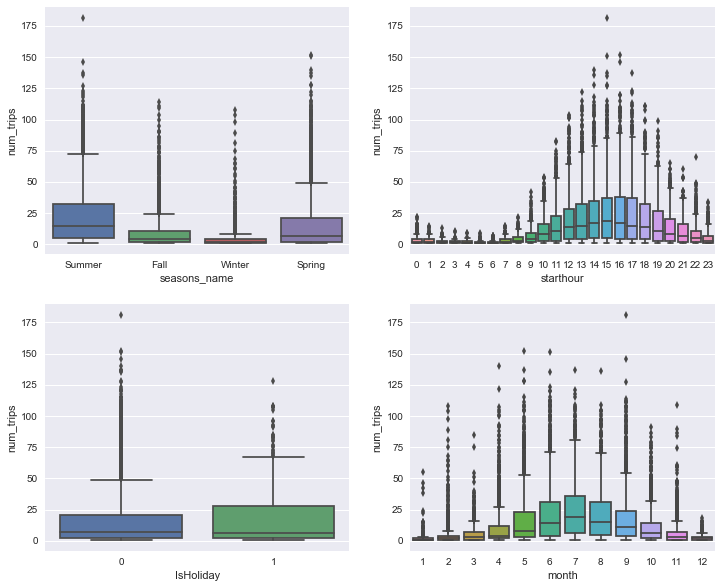

In [28]:
#at from_station_id=35
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=resultData, y="num_trips", x="seasons_name",orient="v",ax=axes[0][0])
sns.boxplot(data=resultData, y="num_trips", x="starthour",orient="v",ax=axes[0][1])
sns.boxplot(data=resultData, y="num_trips", x="IsHoliday", orient="v",ax=axes[1][0])
sns.boxplot(data=resultData, y="num_trips", x="month",orient="v",ax=axes[1][1])

In [153]:
#Categorize variables
categoricalVariables = ["from_station_id","from_station_name","month", "year", "season", "seasons_name", "IsHoliday",
                       "weather", "weatherCode", "day_name", "day", "starthour", "tripdate"]
for var in categoricalVariables:
    resultData[var] = resultData[var].astype("category")

resultData.dtypes


startday                  datetime64[ns]
starthour                       category
from_station_id                 category
num_trips                          int64
from_station_name               category
from_station_latitude            float64
from_station_longitude           float64
day                             category
month                           category
year                            category
day_name                        category
tripdate                        category
season                          category
seasons_name                    category
IsHoliday                       category
weather                         category
humidity                         float64
temperature                      float64
weatherCode                     category
dtype: object

In [31]:
#Outlier are present, will check with model, how model is better without outliers
resultDataWithoutOutliers = resultData[np.abs(resultData["num_trips"]-resultData["num_trips"].mean())<=(3*resultData["num_trips"].std())]

print("Before Ouliers removal: ",resultData.shape)
print("After Ouliers removal: ",resultDataWithoutOutliers.shape)


Before Ouliers removal:  (18224, 18)
After Ouliers removal:  (17851, 18)


In [178]:
#Correlation Analysis

df_numerical = resultData.drop(['from_station_longitude', 'from_station_name', 'day_name', 'seasons_name', 
                     'from_station_latitude', 'weather'], axis=1)

df_numerical.head()
df_numerical.corr()

,num_trips,humidity,temperature
num_trips,1.000000,-0.369624,0.490936
humidity,-0.369624,1.000000,-0.115452
temperature,0.490936,-0.115452,1.000000


In [180]:
df_numerical.set_index(['startday', 'starthour'])
df_sorted = df_numerical.sort_index(level='startday')

df_sorted.head()

,startday,starthour,from_station_id,num_trips,day,month,year,tripdate,season,IsHoliday,humidity,temperature,weatherCode
0,2013-08-05,16,35,11,0,8,2013,5,1,0,0.63,72.11,3
1,2013-08-05,17,35,9,0,8,2013,5,1,0,0.69,70.54,1
2,2013-08-05,18,35,6,0,8,2013,5,1,0,0.72,69.21,1
3,2013-08-05,19,35,12,0,8,2013,5,1,0,0.74,69.06,2
4,2013-08-05,20,35,4,0,8,2013,5,1,0,0.73,69.17,1


In [324]:
#defining method to Test for stationary with ADF test
from statsmodels.tsa.stattools import adfuller
def isStationary(tsData):

    rollingmean = pd.rolling_mean(tsData, window=7, min_periods=1)
    rollingstd = pd.rolling_std(tsData, window=7, min_periods=1)

    fig = plt.figure(figsize=(15, 8))
    orig = plt.plot(tsData, color='blue',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Timeseries data')
    plt.show()
    
    print('ADF Test result:')
    
    result = adfuller(tsData, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
        
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    

C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()
C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).std()


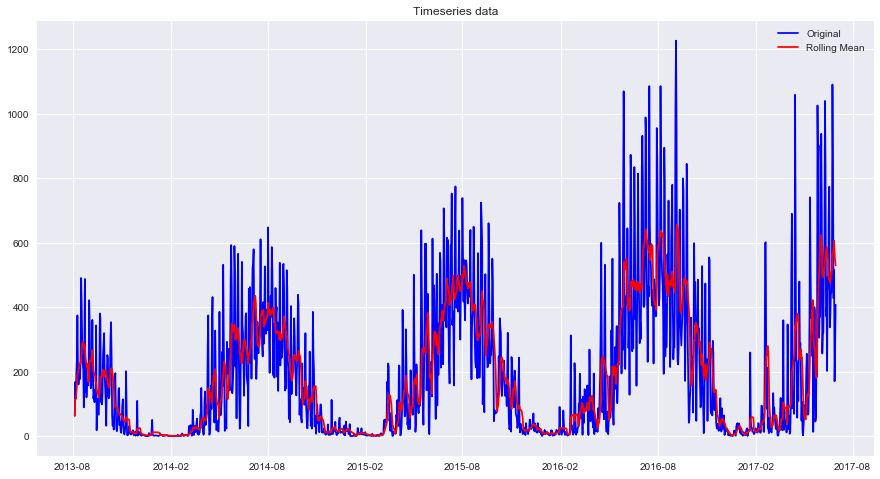

ADF Test result:
ADF Statistic: -1.773164
p-value: 0.393864
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [325]:
#Test for stationary with ADF test
#H0: timeseries data is non-stationary
#H1 timeserise data is stationary

#as p-value is > 0.05
#fail to reject null-hypothesis
#i.e. Data is non-stationary

#Perform Dickey-Fuller test on original data

t4 = df_sorted.groupby(['startday']).num_trips.sum().to_frame()
isStationary(t4.num_trips)

In [192]:
#timeseries data is not stationary. first make it stationary. and then split
print("need to find how to make it stationary")


need to find how to make it stationary


C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()
C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).std()


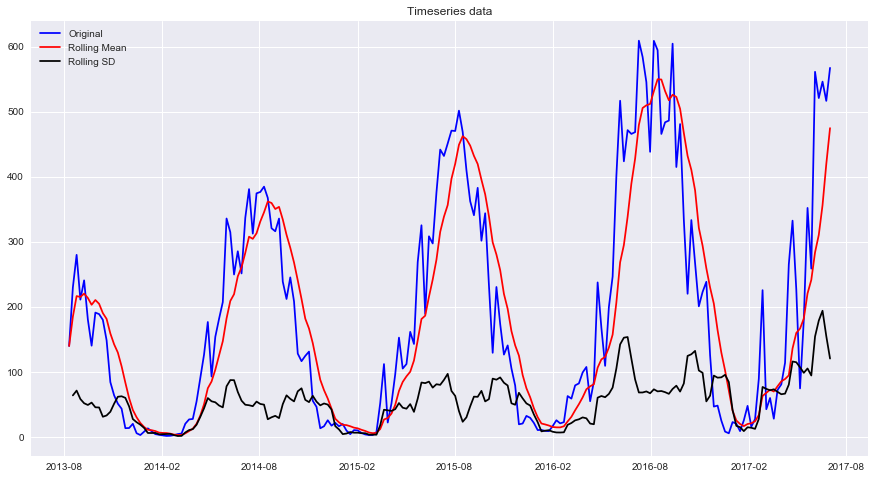

ADF Test result:
ADF Statistic: -4.853727
p-value: 0.000043
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


In [216]:
#sampling weekly
ts_week = t4.resample('W').mean()
ts_week.head()
isStationary(ts_week.mean_num_trips)

C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()
C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).std()


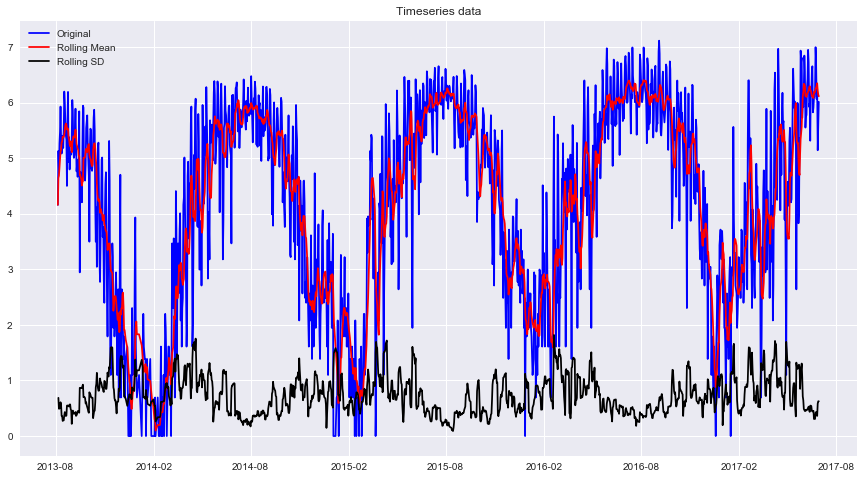

ADF Test result:
ADF Statistic: -2.158506
p-value: 0.221648
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [217]:
from numpy import log

logX = log(t4.num_trips)

isStationary(logX.dropna(inplace=False))

In [193]:
#splitting data into 60%, 20% 20% ration
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

train, validate, test = train_validate_test_split(df_sorted)

In [212]:
#Creating baseline on validation dataset
#mean squared error on validation data
v1 = validate
y = v1.num_trips
y_pred = v1.mean_num_trips

mse = mean_squared_error(y, y_pred)

print("mean squared error: %f" % mse)
print("root mean squared error: %f" % sqrt(mse))


mean squared error: 310.838106
root mean squared error: 17.630601


In [281]:
#Let's build a regression model on non-stationary data
#Select best feature by PCA
from sklearn.decomposition import PCA

df_model = df_sorted[['starthour','day','month','year','season','IsHoliday', 'humidity', 'temperature', 'weatherCode', 'num_trips']]
indepentVar = df_model.values[:, 0:8]
depentVar = df_model.values[:, 8]

pca_train=df_model.drop('num_trips',axis=1)
pca_test=df_model['num_trips']

pca=PCA(n_components=3)
fit = pca.fit(pca_train)
xpca=pca.transform(pca_train)

print("Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

xpca_train=pd.DataFrame(xpca[:],columns=['F1','F2', 'F3'])
xpca_train.head()

Variance: [ 0.85051673  0.10030078  0.02748407]
[[ -3.22374819e-02   1.88689388e-03  -3.73618611e-02   7.69995554e-03
    2.70866407e-02   1.87419418e-04   1.19850657e-03  -9.98375549e-01
    3.61840415e-03]
 [ -9.99376857e-01  -4.82328135e-03   3.69422146e-03   9.39288366e-03
   -6.93876930e-03   2.93440623e-04   6.89109909e-03   3.20156645e-02
    1.92467284e-04]
 [ -2.30787087e-05   1.10691958e-02   9.75771989e-01  -1.86141847e-01
    1.08722363e-01   2.30684941e-04   7.05202731e-03  -3.49788193e-02
   -1.96372827e-03]]


,F1,F2,F3
0,-12.637890,-2.051581,0.962186
1,-11.109843,-3.101194,1.021430
2,-9.814205,-4.142945,1.068140
3,-9.693043,-5.146794,1.071541
4,-9.838733,-6.142910,1.069564


In [327]:
#Root mean square testing after PCA

X = np.array(xpca_train)
y = np.array(pca_test)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)
X_train
clf = LinearRegression(normalize= True)
clf.fit(X_train, y_train)
rmse = sqrt(mean_squared_error(y_test, clf.predict(X_test)))
print("after PCA with 3 compeonents, accuracy of LR is: ", clf.score(X_test, y_test), 
      "\nThe RMSE is: ", rmse)
print("cofficient: " , clf.coef_)
print("intercepter: ", clf.intercept_)

after PCA with 3 compeonents, accuracy of LR is:  0.277191433025 
The RMSE is:  15.826703675621873
cofficient:  [-0.56566489 -0.53992785 -0.51687354]
intercepter:  14.4433047535


In [316]:
#cross-validation. need more information?
from sklearn.model_selection import cross_val_score
kscore=cross_val_score(clf,xpca_train,pca_test,scoring='r2',cv=10)
kscore.mean()

0.14813071684102405

In [287]:
from sklearn.feature_selection import SelectKBest, f_classif
#Suppose, we select 7 features with top 7 Fisher scores
selector = SelectKBest(f_classif, k = 7)
selector.fit(indepentVar, depentVar)

#idxs_selected = selector.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
#features_dataframe_new = indepentVar[idxs_selected]

names = df_model.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feature', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feature'], ascending = [False, True])
print(ns_df_sorted)

#X_new = selector.fit_transform(indepentVar, depentVar)
#X_new

       Feature    F_Scores
5     humidity  295.961175
6  temperature   61.005061
3         year   20.814000
1          day    9.089004
0    starthour    3.939950
2        month    3.824385
4       season    2.453823


C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 8


C:\_Apps\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


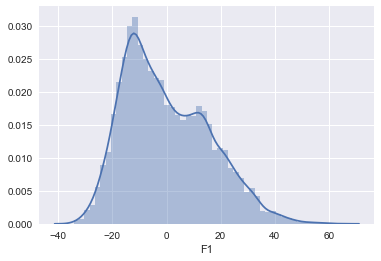

In [328]:
sns.distplot(xpca_train['F1'])

In [317]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200,random_state=0)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.57130121209322304

In [319]:
rfkscore=cross_val_score(rf,xpca_train,pca_test,scoring='r2',cv=5)
rfkscore.mean()

0.37958372795127693